<a href="https://colab.research.google.com/github/ishanmalviya10/NASA/blob/Ishan-(QML-algorithms)/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving pune_dataset.csv to pune_dataset (5).csv
User uploaded file "pune_dataset (5).csv" with length 1032 bytes


,datetime_UTC,PM2.5_ugm3,NO2_ppb,temp_C,RH_percent,wind_spd_ms,wind_dir_deg,BLH_m,AOD_MODIS,NO2_TROPOMI_molm2,pressure_hPa,precip_mm,lat,lon
0,2024-11-01T00:00:00,187.3,42.1,18.2,68,1.2,310,280,0.58,0.000082,1015.0,0,18.5204,73.8567
1,2024-11-01T01:00:00,201.5,45.3,17.8,71,1.0,295,240,NaN,NaN,1015.5,0,18.5204,73.8567
2,2024-11-01T02:00:00,218.7,48.2,17.3,74,0.9,285,220,NaN,NaN,1016.0,0,18.5204,73.8567
3,2024-11-01T03:00:00,235.2,51.0,16.9,77,0.8,275,200,NaN,NaN,1016.5,0,18.5204,73.8567
4,2024-11-01T04:00:00,248.6,53.5,16.5,79,0.7,270,180,NaN,NaN,1017.0,0,18.5204,73.8567


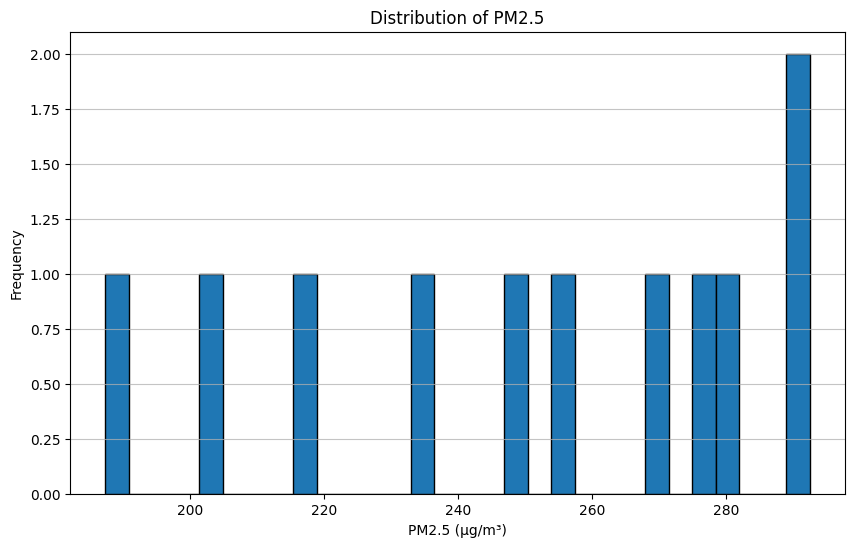

🔄 Training XGBoost Regressor...

📈 XGBoost Regression Results:
  MAE:  13.79 µg/m³
  RMSE: 17.89 µg/m³
  R²:   0.825

🔄 Training XGBoost Classifier...


XGBoostError: [19:48:28] /workspace/src/objective/./regression_loss.h:68: Check failed: base_score > 0.0f && base_score < 1.0f: base_score must be in (0,1) for logistic loss, got: 0
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x2a6e7c) [0x7e7154aa6e7c]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0xeda699) [0x7e71556da699]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x6826d3) [0x7e7154e826d3]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x682a9c) [0x7e7154e82a9c]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x68cfeb) [0x7e7154e8cfeb]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x77) [0x7e71549b6f57]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e7199171e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e719916e493]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7e719a3958c1]



In [8]:
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Assuming the uploaded file is a CSV, load it into a pandas DataFrame
  df = pd.read_csv(fn)

# Display the first 5 rows of the DataFrame
display(df.head())

# Plot histogram of 'PM2.5_ugm3'
plt.figure(figsize=(10, 6))
plt.hist(df['PM2.5_ugm3'].dropna(), bins=30, edgecolor='black')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Frequency')
plt.title('Distribution of PM2.5')
plt.grid(axis='y', alpha=0.75)
plt.show()


feature_cols = ['temp_C', 'RH_percent', 'wind_spd_ms', 'BLH_m',
                'pressure_hPa', 'AOD_MODIS', 'NO2_TROPOMI_molm2']

X = df[feature_cols].values
y_reg = df['PM2.5_ugm3'].values

# Adjust the threshold for 'exceedance' here
# Note: Adjusted to a high value to ensure both classes (0 and 1) exist in this specific dataset
# For your actual analysis, choose a threshold meaningful to your definition of "exceedance"
exceedance_threshold = 300 # Example: Adjusted to a high value
y_class = (df['PM2.5_ugm3'] > exceedance_threshold).astype(int).values


X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)
_, _, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("🔄 Training XGBoost Regressor...")
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_reg.fit(X_train_scaled, y_train_reg)

y_pred_reg = xgb_reg.predict(X_test_scaled)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n📈 XGBoost Regression Results:")
print(f"  MAE:  {mae:.2f} µg/m³")
print(f"  RMSE: {rmse:.2f} µg/m³")
print(f"  R²:   {r2:.3f}")

print("\n🔄 Training XGBoost Classifier...")
xgb_class = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)
xgb_class.fit(X_train_scaled, y_train_class)

y_pred_class = xgb_class.predict(X_test_scaled)

print("\n📊 XGBoost Classification Results:")
print(classification_report(y_test_class, y_pred_class,
                          target_names=['No Exceedance', 'Exceedance']))

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Exc', 'Exc'],
            yticklabels=['No Exc', 'Exc'])
plt.title('Confusion Matrix: Exceedance Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

importance = xgb_reg.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✅ Classical baseline established!")